In [1]:
import pandas as pd
import natsort
from glob import glob
from sympy import *
import numpy as np

In [2]:
gamma1,gamma2,beta,theta=symbols('gamma1 gamma2 beta theta',real=True)
def N_mach(N,k):
    if k==1:
        lista=list()
        K=symarray('theta', N+1,real=True)
        for i in range(1,N+1):
            l=i
            BS=Matrix([[cos(K[i]),I*sin(K[i])],[I*sin(K[i]),cos(K[i])]])
            lista.append(BS)
    else:
        t=Symbol('theta1',real=True)
        lista=Matrix([[cos(t/N),I*sin(t/N)],[I*sin(t/N),cos(t/N)]])
    return lista
def N_mach_zehnder(N,k):
    K=N_mach(N,k)
    jones1= Matrix([0,1])
    jones0= Matrix([1,0])
    M1=Matrix([[0,exp(I*gamma2)],[exp(I*gamma1),0]])
    objeto=Matrix([[ beta,0],[0,1]])
    r=jones0
    if k==1:
        for i in range(0,N):
            if i==N-1:
                r=simplify(K[i]*r)
            else:
                r=simplify(M1*objeto*K[i]*r)
    else:
        r=K*(M1*objeto*K)**(N-1)*r
    return r
        
def N_Interferomemer(N,k):
    jones1= Matrix([0,1])
    jones0= Matrix([1,0])
    r=N_mach_zehnder(N,k)
    p1=jones0.T*r
    p1=p1[0]*conjugate(p1[0])
    p1=re(p1)
    p2=jones1.T*r
    p2=p2[0]*conjugate(p2[0])
    p2=re(p2)
    pabs=1-p1-p2
    K=symarray('theta', N+1,real=True)
    return pabs,p1,p2,K

In [3]:
valores=[0,np.pi/18,np.pi/9,np.pi/6,40*np.pi/180,50*np.pi/180,np.pi/3,7*np.pi/18,8*np.pi/18,np.pi/2]
valores

[0,
 0.17453292519943295,
 0.3490658503988659,
 0.5235987755982988,
 0.6981317007977318,
 0.8726646259971648,
 1.0471975511965976,
 1.2217304763960306,
 1.3962634015954636,
 1.5707963267948966]

In [4]:
filenames = glob('/home/mcditoos/Desktop/DatosGerardo2/21/gerardo*.DAT')

filenames=natsort.natsorted(filenames)
C=pd.read_csv(filenames[0],sep='\t')
lista=C.columns
sem1=np.array([])
Coincidencias1=np.array([])
for i in filenames:
    C=pd.read_csv(i,sep='\t')
    C=C.drop([lista[0],lista[1],lista[2],lista[3],lista[5],lista[7]],axis=1)
    promedio=C[lista[8]].mean()
    SEM1=C[lista[8]].std()
    sem1=np.append(sem1,SEM1)
    Coincidencias1=np.append(Coincidencias1,promedio)

coincidencias1=Coincidencias1[1:]


In [5]:
filenames = glob('/home/mcditoos/Desktop/DatosGerardo2/11/gerardo*.DAT')

filenames=natsort.natsorted(filenames)
sem2=np.array([])
Coincidencias2=np.array([])
for i in filenames:
    C=pd.read_csv(i,sep='\t')
    C=C.drop([lista[0],lista[1],lista[2],lista[3],lista[5],lista[7]],axis=1)
    promedio=C[lista[8]].mean()
    SEM2=C[lista[8]].std()
    sem2=np.append(sem2,SEM2)
    Coincidencias2=np.append(Coincidencias2,promedio)
coincidencias2=Coincidencias2[1:]


In [6]:
total=6262.23

In [7]:
coincidencias1=coincidencias1/total
coincidencias2=coincidencias2/total
haha=sem2[1:]/total
haha1=sem1[1:]/total

In [8]:
theta1,theta2,Delta=symbols('theta1 theta2 Delta',real=True)
pabs,pd1,pd2,K=N_Interferomemer(2,1)
pd2=simplify(pd2.subs({K[1]:np.pi/4,K[2]:np.pi/4,beta:cos(theta)}))
pd2=pd2.subs(gamma1-gamma2,Delta)
f2 = lambdify([theta,Delta], pd2)
pd1=simplify(pd1.subs({K[1]:np.pi/4,K[2]:np.pi/4,beta:cos(theta),gamma1-gamma2:Delta}))
pd1=pd1.subs(gamma1-gamma2,Delta)
f1 = lambdify([theta,Delta], pd1)

Parameters [1.37611443]
RMSE: 0.12733856461731632
R-squared: -58.48743368873626


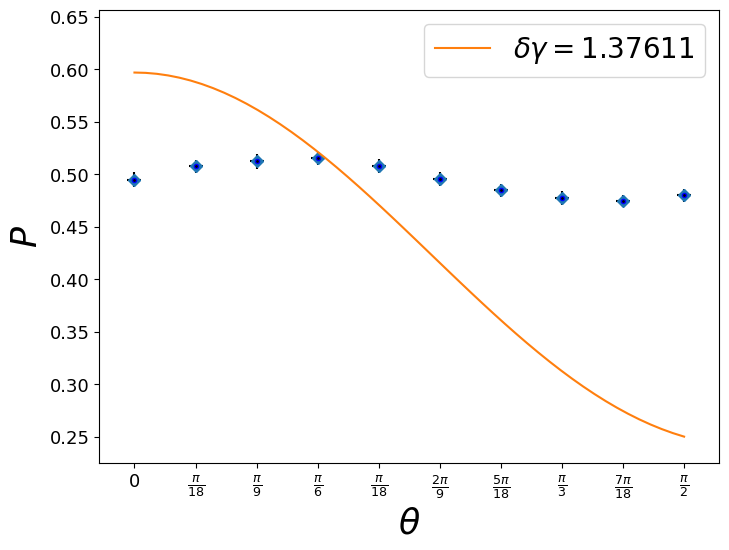

In [10]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

xData = valores
yData = coincidencias2


def func(x,gamma1): # Sigmoid A With Offset from zunzun.com
    return  f1(x,gamma1)


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    #parameterBounds.append([0.684719203, 0.83548187397]) # search bounds for a
    #parameterBounds.append([0.684719203, 0.83548187397]) # search bounds for b
    #parameterBounds.append([0.684719203, maxX]) # search bounds for b
    parameterBounds.append([0, maxX]) # search bounds for b

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
handler=r'$\delta\gamma=$'+str(round(fittedParameters[0], 5))

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)



##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot 
    axes.plot(xModel, yModel,label=handler)

    axes.set_ylabel(r'$P$',size=25) # X axis data label
    axes.set_xlabel(r'$\theta$',size=25) # Y axis data label
    plt.ylim(min(yModel)-(min(yModel)/10),max(yModel)+(max(yModel)/10))
    plt.errorbar(xData, yData, haha1,0.02, marker='.',mec='b',mfc='black',color='black',ls='none')
    plt.yticks(size=13)
    plt.xticks([0,np.pi/18,np.pi/9,np.pi/6,40*np.pi/180,50*np.pi/180,np.pi/3,7*np.pi/18,8*np.pi/18,np.pi/2],[r'$0$',r'$\frac{\pi}{18}$',r'$\frac{\pi}{9}$',r'$\frac{\pi}{6}$',
                                                                                                             r'$\frac{\pi}{18}$',r'$\frac{2\pi}{9}$',r'$\frac{5\pi}{18}$',r'$\frac{\pi}{3}$',
                                                                                                            r'$\frac{7\pi}{18}$',r'$\frac{\pi}{2}$',],size=13)
    plt.legend(fontsize=20)
    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

Parameters [1.19169537]
RMSE: 0.01038758965036368
R-squared: 0.8930048825805807


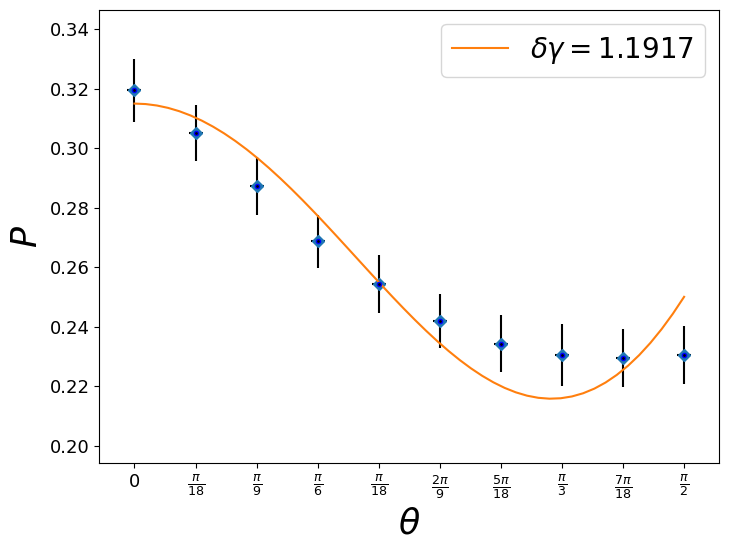

In [11]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

xData = valores
yData = coincidencias1


def func(x,gamma1): # Sigmoid A With Offset from zunzun.com
    return  f2(x,gamma1)


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    #parameterBounds.append([0.684719203, 0.83548187397]) # search bounds for a
    #parameterBounds.append([0.684719203, 0.83548187397]) # search bounds for b
    parameterBounds.append([0, maxX]) # search bounds for b
   # parameterBounds.append([0.684719203, maxX]) # search bounds for b

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
handler=r'$\delta\gamma=$'+str(round(fittedParameters[0], 5))

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)



##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot 
    axes.plot(xModel, yModel,label=handler)

    axes.set_ylabel(r'$P$',size=25) # X axis data label
    axes.set_xlabel(r'$\theta$',size=25) # Y axis data label
    plt.ylim(min(yModel)-(min(yModel)/10),max(yModel)+(max(yModel)/10))
    plt.errorbar(xData, yData, haha,0.02, marker='.',mec='b',mfc='black',color='black',ls='none')
    plt.yticks(size=13)
    plt.xticks([0,np.pi/18,np.pi/9,np.pi/6,40*np.pi/180,50*np.pi/180,np.pi/3,7*np.pi/18,8*np.pi/18,np.pi/2],[r'$0$',r'$\frac{\pi}{18}$',r'$\frac{\pi}{9}$',r'$\frac{\pi}{6}$',
                                                                                                             r'$\frac{\pi}{18}$',r'$\frac{2\pi}{9}$',r'$\frac{5\pi}{18}$',r'$\frac{\pi}{3}$',
                                                                                                            r'$\frac{7\pi}{18}$',r'$\frac{\pi}{2}$',],size=13)
    plt.legend(fontsize=20)
    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

# Mediciones del jueves

In [12]:
filenames = glob('/home/mcditoos/Desktop/DatosGerardo2/jueves/h/21/gerardo*.DAT')

filenames=natsort.natsorted(filenames,reverse=True)
C=pd.read_csv(filenames[0],sep='\t')
lista=C.columns
sem1=[]
Coincidencias1=np.array([])
for i in filenames:
    C=pd.read_csv(i,sep='\t')
    C=C.drop([lista[0],lista[1],lista[2],lista[3],lista[5],lista[7]],axis=1)
    promedio=C[lista[8]].mean()
    SEM1=C[lista[8]].std()
    sem1.append(SEM1)
    Coincidencias1=np.append(Coincidencias1,promedio)

coincidencias1=Coincidencias1[:10]


In [13]:
filenames = glob('/home/mcditoos/Desktop/DatosGerardo2/jueves/h/11/gerardo*.DAT')

filenames=natsort.natsorted(filenames,reverse=True)
sem2=[]
Coincidencias2=np.array([])
for i in filenames:
    C=pd.read_csv(i,sep='\t')
    C=C.drop([lista[0],lista[1],lista[2],lista[3],lista[5],lista[7]],axis=1)
    promedio=C[lista[8]].mean()
    SEM2=C[lista[8]].std()
    sem2.append(SEM2)
    Coincidencias2=np.append(Coincidencias2,promedio)
coincidencias2=Coincidencias2[:10]

In [14]:
total=Coincidencias1[10]+Coincidencias2[11]
total

4983.085

In [15]:
coincidencias1=coincidencias1/total
coincidencias2=coincidencias2/total
haha=sem2[:10]/total
haha1=sem1[:10]/total

In [16]:
theta1,theta2,Delta=symbols('theta1 theta2 Delta',real=True)
pabs,pd1,pd2,K=N_Interferomemer(2,1)
pd2=simplify(pd2.subs({K[1]:np.pi/4,K[2]:np.pi/4,beta:cos(theta)}))
pd2=pd2.subs(gamma1-gamma2,Delta)
f2 = lambdify([theta,Delta], pd2)
pd1=simplify(pd1.subs({K[1]:np.pi/4,K[2]:np.pi/4,beta:cos(theta),gamma1-gamma2:Delta}))
pd1=pd1.subs(gamma1-gamma2,Delta)
f1 = lambdify([theta,Delta], pd1)

Parameters [1.80041494]
RMSE: 0.015122865359817095
R-squared: 0.8950913960165544


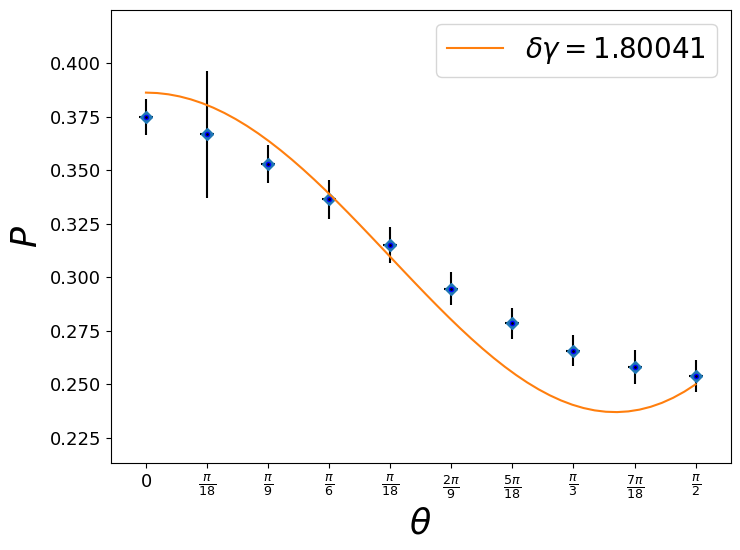

In [17]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

xData = valores
yData = coincidencias2


def func(x,gamma1): # Sigmoid A With Offset from zunzun.com
    return  f1(x,gamma1)


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    #parameterBounds.append([0.684719203, 0.83548187397]) # search bounds for a
    #parameterBounds.append([0.684719203, 0.83548187397]) # search bounds for b
    parameterBounds.append([0, maxX]) # search bounds for b
   # parameterBounds.append([0.684719203, maxX]) # search bounds for b

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
handler=r'$\delta\gamma=$'+str(round(fittedParameters[0], 5))

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)



##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot 
    axes.plot(xModel, yModel,label=handler)

    axes.set_ylabel(r'$P$',size=25) # X axis data label
    axes.set_xlabel(r'$\theta$',size=25) # Y axis data label
    plt.ylim(min(yModel)-(min(yModel)/10),max(yModel)+(max(yModel)/10))
    plt.errorbar(xData, yData, haha,0.02, marker='.',mec='b',mfc='black',color='black',ls='none')
    plt.yticks(size=13)
    plt.xticks([0,np.pi/18,np.pi/9,np.pi/6,40*np.pi/180,50*np.pi/180,np.pi/3,7*np.pi/18,8*np.pi/18,np.pi/2],[r'$0$',r'$\frac{\pi}{18}$',r'$\frac{\pi}{9}$',r'$\frac{\pi}{6}$',
                                                                                                             r'$\frac{\pi}{18}$',r'$\frac{2\pi}{9}$',r'$\frac{5\pi}{18}$',r'$\frac{\pi}{3}$',
                                                                                                            r'$\frac{7\pi}{18}$',r'$\frac{\pi}{2}$',],size=13)
    plt.legend(fontsize=20)
    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

In [27]:
coincidencias1

array([0.38567474, 0.37791582, 0.35307732, 0.36418002, 0.35347581,
       0.32671427, 0.30937762, 0.29610272, 0.28634169, 0.28191773])

Parameters [1.39297906]
RMSE: 0.0332019941947942
R-squared: 0.30858581310251476


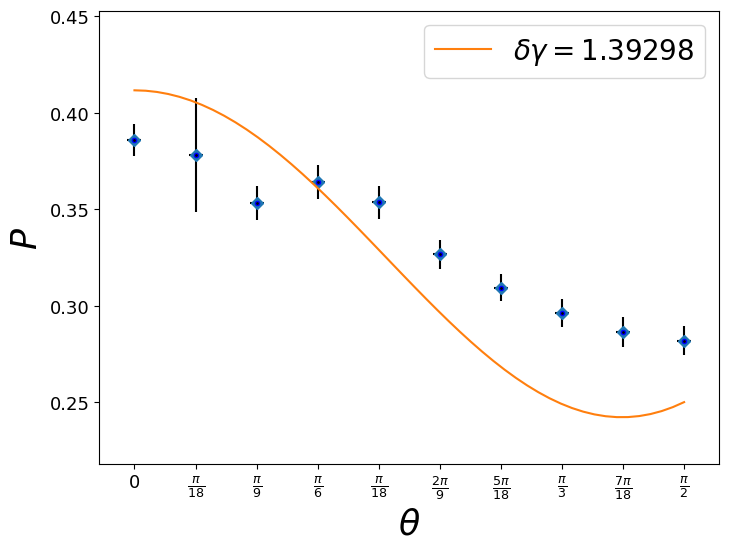

In [18]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

xData = valores
yData = coincidencias1


def func(x,gamma1): # Sigmoid A With Offset from zunzun.com
    return  f2(x,gamma1)


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    #parameterBounds.append([0.684719203, 0.83548187397]) # search bounds for a
    #parameterBounds.append([0.684719203, 0.83548187397]) # search bounds for b
    parameterBounds.append([0, maxX]) # search bounds for b
   # parameterBounds.append([0.684719203, maxX]) # search bounds for b

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
handler=r'$\delta\gamma=$'+str(round(fittedParameters[0], 5))

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)



##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot 
    axes.plot(xModel, yModel,label=handler)

    axes.set_ylabel(r'$P$',size=25) # X axis data label
    axes.set_xlabel(r'$\theta$',size=25) # Y axis data label
    plt.ylim(min(yModel)-(min(yModel)/10),max(yModel)+(max(yModel)/10))
    plt.errorbar(xData, yData, haha,0.02, marker='.',mec='b',mfc='black',color='black',ls='none')
    plt.yticks(size=13)
    plt.xticks([0,np.pi/18,np.pi/9,np.pi/6,40*np.pi/180,50*np.pi/180,np.pi/3,7*np.pi/18,8*np.pi/18,np.pi/2],[r'$0$',r'$\frac{\pi}{18}$',r'$\frac{\pi}{9}$',r'$\frac{\pi}{6}$',
                                                                                                             r'$\frac{\pi}{18}$',r'$\frac{2\pi}{9}$',r'$\frac{5\pi}{18}$',r'$\frac{\pi}{3}$',
                                                                                                            r'$\frac{7\pi}{18}$',r'$\frac{\pi}{2}$',],size=13)
    plt.legend(fontsize=20)
    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

In [19]:
f2(valores,1.80041494)

array([0.61380308, 0.60453573, 0.57769547, 0.53605636, 0.48388424,
       0.42644519, 0.36940154, 0.31816739, 0.27730012, 0.25      ])

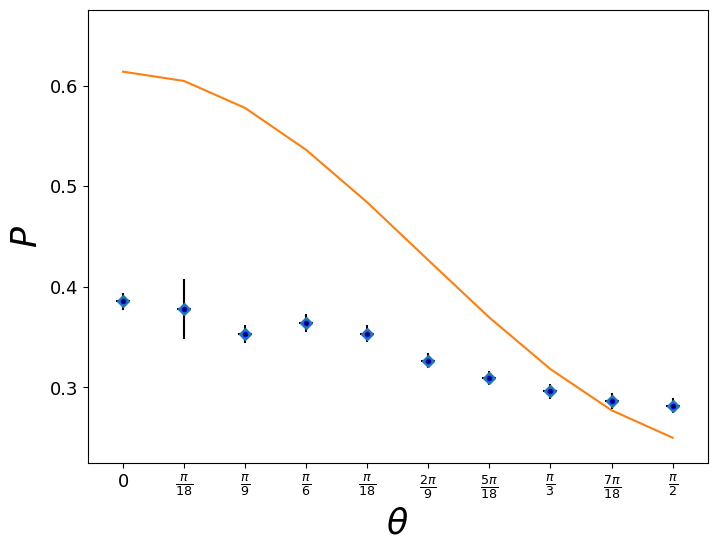

In [20]:
f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
axes = f.add_subplot(111)
xData=valores
yData=coincidencias1
# first the raw data as a scatter plot
axes.plot(xData, yData,  'D')

# create data for the fitted equation plot
xModel = valores
yModel = f2(valores,1.80041494)

    # now the model as a line plot 
axes.plot(xModel, yModel)

axes.set_ylabel(r'$P$',size=25) # X axis data label
axes.set_xlabel(r'$\theta$',size=25) # Y axis data label
plt.ylim(min(yModel)-(min(yModel)/10),max(yModel)+(max(yModel)/10))
plt.errorbar(xData, yData, haha,0.02, marker='.',mec='b',mfc='black',color='black',ls='none')
plt.yticks(size=13)
plt.xticks([0,np.pi/18,np.pi/9,np.pi/6,40*np.pi/180,50*np.pi/180,np.pi/3,7*np.pi/18,8*np.pi/18,np.pi/2],[r'$0$',r'$\frac{\pi}{18}$',r'$\frac{\pi}{9}$',r'$\frac{\pi}{6}$',
                                                                                                             r'$\frac{\pi}{18}$',r'$\frac{2\pi}{9}$',r'$\frac{5\pi}{18}$',r'$\frac{\pi}{3}$',
                                                                                                            r'$\frac{7\pi}{18}$',r'$\frac{\pi}{2}$',],size=13)
plt.show()
plt.close('all') # clean up after using pyplot